<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Text Normalization

by Fabian Märki

## Summary
The aim of this notebook is to show how text can be tokenized, stemmed, lemmanized in order to prepare it as training data for a downstream nlp task. Additionally, it visualizes the data in various ways in order to decide upon reasonable stopwords for the training data at hand. It then uses some simple count features to identify malformed/outlier data that should be removed from the training dataset.

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2021_HS_CAS_NLP_LAB_Notebooks/blob/master/02_b_Text_Normalization.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.2.13,<0.3.0'

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.text import join_tokens

import pandas as pd
import numpy as np

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.11.0-40-generic
Python version: 3.6.9
Tensorflow version: 2.5.1
GPU is available


In [3]:
%%time
download("https://drive.google.com/uc?id=157B_040GQF3bBmla-VUzrzRfVFdkBjec", "data/german_doctor_reviews_cleaned.parq")
data = load_dataframe("data/german_doctor_reviews_cleaned.parq")
data.shape

CPU times: user 1.33 s, sys: 283 ms, total: 1.61 s
Wall time: 1.16 s


(350097, 3)

In [4]:
data.head(3)

,text_original,rating,text
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...


Helper functions for tokenization, stemming and lemmantization

<font color='red'>**TASK: Implement `tokenize` and `tokenize_stem` and provide the functionality as described in the function documentation.**</font>

In [5]:
def tokenize(text, stopwords):
    """Tokenizes and lowercases a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
        
    Returns
    -------
    list
        The tokenized text
    """
    from fhnw.nlp.utils.processing import is_iterable
    
    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        word_tokens = word_tokenize(text)
    elif is_iterable(text):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))

    # TODO: !!! place your code here !!!
    ####################################


    ###################
    # TODO: !!! end !!!
    
    return word_tokens


def tokenize_stem(text, stopwords, stemmer):
    """Tokenizes, lowercases and stems a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer)
        
    Returns
    -------
    list
        The tokenized and stemmed text
    """
    from fhnw.nlp.utils.processing import is_iterable
        
    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        word_tokens = word_tokenize(text)
    elif is_iterable(text):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))

    # TODO: !!! place your code here !!!
    ####################################


    ###################
    # TODO: !!! end !!!
        
    return word_tokens


def tokenize_lemma(text, stopwords, lemmanizer, keep_ners=False):
    """Tokenizes, lowercases and lemmatizes a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline)
    keep_ner: bool
        Defines if named entities (NERs) should be keept in one token
        
    Returns
    -------
    list
        The tokenized and lemmatized text
    """
    from fhnw.nlp.utils.processing import is_iterable
        
    if isinstance(text, str):
        text = text
    elif is_iterable(text):
        from fhnw.nlp.utils.text import join_tokens
        text = join_tokens(text, set())
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))  
    
    if keep_ners:
        # HanoverTagger could be an alternative but takes longer 
        # see: https://textmining.wp.hs-hannover.de/Preprocessing.html#Lemmatisierung-und-Wortarterkennung
        doc = lemmanizer(text, disable=['tagger', 'parser'])

        tokens = list()
        ner_idx = 0
        tok_idx = 0

        # keep ner in one token
        while tok_idx < len(doc):
            if ner_idx >= len(doc.ents) or doc[tok_idx].idx < doc.ents[ner_idx].start_char:
                if doc[tok_idx].is_alpha and not doc[tok_idx].is_punct and doc[tok_idx].text.lower() not in stopwords and doc[tok_idx].lemma_.lower() not in stopwords:
                    #print("token ", doc[tok_idx].lemma_.lower())
                    tokens.append(doc[tok_idx].lemma_.lower())

                tok_idx += 1
            else:
                #print("ner ", doc.ents[ner_idx].lemma_.lower())
                tokens.append(doc.ents[ner_idx].lemma_.lower())

                tok_idx += 1
                while tok_idx < len(doc) and doc[tok_idx].idx < doc.ents[ner_idx].end_char:
                    tok_idx += 1

                ner_idx += 1

        return tokens
    else:
        doc = lemmanizer(text, disable=['tagger', 'parser', 'ner']) 
        return [tok.lemma_.lower() for tok in doc if tok.is_alpha and not tok.is_punct and tok.text.lower() not in stopwords and tok.lemma_.lower() not in stopwords]


def normalize(text, stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False):
    """Normalizes (e.g. tokenize and stem) and lowercases a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer) or None to disable stemming
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline) or None to disable lemmantization
    lemma_with_ner: bool
        Defines if named entities (NERs) should be keept in one token
        
    Returns
    -------
    list
        The normalized text
    """
        
    if lemmanizer is not None:
        return tokenize_lemma(text, stopwords, lemmanizer, keep_ners=lemma_with_ner)
    elif stemmer is not None:
        return tokenize_stem(text, stopwords, stemmer)
    else:
        return tokenize(text, stopwords)

In [6]:
%%capture

!pip install 'spacy>=3.0.5'
!pip install nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import spacy
!python3 -m spacy download de_core_news_md

nlp = spacy.load("de_core_news_md")

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stopwords = set(stopwords.words("german"))
#stopwords = set(nlp.Defaults.stop_words)
empty_stopwords = set()

Let's test some examples:

In [7]:
print(tokenize("Ein guter Arzt.", stopwords=stopwords))
print(tokenize_stem("Ein guter Arzt.", stopwords=stopwords, stemmer=stemmer))

['guter', 'arzt', '.']
['gut', 'arzt', '.']


### Setup Sentiment

The classification should recognize if a comment has a positive or negative sentiment. Let's assume that a good rating (1-2) caries a positive message whereas a low rating (5-6) caries a negative one (later we will exclude neutral ratings, i.e. the task becomes a binary classification).

In [8]:
data["label"] = "positive"
data.loc[data["rating"] >= 3, "label"] = "neutral"
data.loc[data["rating"] >= 5, "label"] = "negative"

data["sentiment"] = data["label"].apply(lambda x: 1 if x == "positive" else (-1 if x == "negative" else 0))
data = data.astype({"sentiment": "int32"})

In [9]:
data.head(3)

,text_original,rating,text,label,sentiment
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1


### Setup Stopwords

Get the (lowercased) tokens first without removing stopwords in order to come up with a *reasonable* set of stopwords.

In [10]:
%%time
data = parallelize_dataframe(data, normalize, field_read="text", field_write="token_clean", stopwords=empty_stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False)

CPU times: user 10.9 s, sys: 1.14 s, total: 12.1 s
Wall time: 49.2 s


Join the lowercased tokens again since some algorithms used later need text instead of tokens.

In [11]:
%%time
data = parallelize_dataframe(data, join_tokens, field_read="token_clean", field_write="text_clean", stopwords=empty_stopwords)

CPU times: user 1min 16s, sys: 2.82 s, total: 1min 18s
Wall time: 1min 20s


Define the stopwords and use n-gram counts and wordclouds to decide upon words to add to the stopwords.

In [12]:
%%capture

!pip install nltk

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = set(stopwords.words("german"))

In [13]:
print(stopwords)

{'wollen', 'dann', 'solchem', 'unter', 'bei', 'jetzt', 'manche', 'dein', 'hab', 'seinem', 'sind', 'dessen', 'wirst', 'oder', 'unseren', 'denn', 'in', 'ihn', 'jedes', 'nur', 'als', 'unser', 'dieses', 'ins', 'doch', 'eines', 'keiner', 'wenn', 'anderem', 'das', 'kein', 'die', 'zwischen', 'jenen', 'allen', 'manchen', 'alles', 'aber', 'du', 'aus', 'meines', 'während', 'meinen', 'nicht', 'deinen', 'ob', 'keines', 'meiner', 'mit', 'sonst', 'unseres', 'dass', 'wir', 'alle', 'deine', 'desselben', 'einig', 'im', 'uns', 'ich', 'der', 'waren', 'deiner', 'da', 'einigen', 'selbst', 'anders', 'vor', 'gegen', 'eurem', 'ist', 'soll', 'sollte', 'ohne', 'einigem', 'vom', 'mir', 'kann', 'werde', 'dies', 'viel', 'euren', 'seiner', 'jedem', 'denselben', 'warst', 'diesem', 'ihrer', 'also', 'solches', 'keine', 'andere', 'anderr', 'von', 'damit', 'ihren', 'welches', 'nach', 'dieselben', 'allem', 'machen', 'sie', 'es', 'am', 'gewesen', 'noch', 'sondern', 'einige', 'eurer', 'muss', 'dort', 'jede', 'jenem', 'zwar

In [14]:
%%time
data = parallelize_dataframe(data, normalize, field_read="token_clean", field_write="token_lemma", stopwords=stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False)

CPU times: user 3min 44s, sys: 9.5 s, total: 3min 53s
Wall time: 6min 29s


Store the work so far (so we could resume if needed).

In [15]:
%%time
save_dataframe(data, "data/german_doctor_reviews_pre_tokenized_01.parq")

CPU times: user 51.6 s, sys: 758 ms, total: 52.4 s
Wall time: 52.3 s


Resume if needed...

In [16]:
%%time

#data = None
if data is None:
    download("https://drive.google.com/uc?id=1-qNGdlOY4SRFVNmhdNibAnNqfqvdhAqo", "data/german_doctor_reviews_pre_tokenized_01.parq")
    data = load_dataframe("data/german_doctor_reviews_pre_tokenized_01.parq")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [17]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, herr, magura, erst..."


Let's see how frequent the words (and their n-grams) are...

<font color='red'>**TASK: Implement `create_ngram_counts` and provide the functionality as described in the function documentation.**</font>

Possible Inspirations:
- [Apply function to a single DataFrame column](https://stackoverflow.com/a/34962199)
- [Create n-grams](https://stackoverflow.com/a/32307986)
- [collections.Counter](https://docs.python.org/3/library/collections.html#collections.Counter)

In [18]:
def create_ngram_counts(df, n = 2, field_read="token_lemma"):
    """Creates the n-gram counts of a column of text tokens

    Parameters
    ----------
    df : dataframe
        The dataframe
    n : int
        The n grams to create (e.g. 2 for bi-gram)
    field_read : str
        The column name to read from (default is token_lemma)
        
    Returns
    -------
    Counter
        The n-gram counts
    """
    from collections import Counter
        
    counter = Counter()
    
    # TODO: !!! place your code here !!!
    ####################################
 

    ###################
    # TODO: !!! end !!!
    
    return counter


def plot_ngram_counts(counter, n_most_common, title="Term frequencies"):
    """Plots the n-gram counts

    Parameters
    ----------
    counter : Counter
        The counter of the n-grams
    n_most_common : int
        The n most common n-grams to plog
    title : str
        The title of the plot
    """
    
    import matplotlib.pyplot as plt
        
    y = [count for tag, count in counter.most_common(n_most_common)]
    x = [tag for tag, count in counter.most_common(n_most_common)]

    plt.bar(x, y)
    plt.title(title)
    plt.ylabel("Frequency")
    #plt.yscale('log') # set log scale for y-axis
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(counter.most_common(n_most_common)):
        plt.text(i, count, f' {count} ', rotation=90, ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
    plt.xlim(-0.6, len(x)-0.4) # set tighter x lims
    plt.tight_layout() # change the whitespace such that all labels fit nicely
    plt.show()

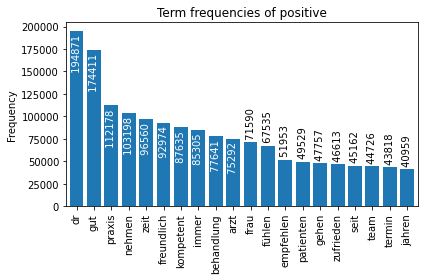

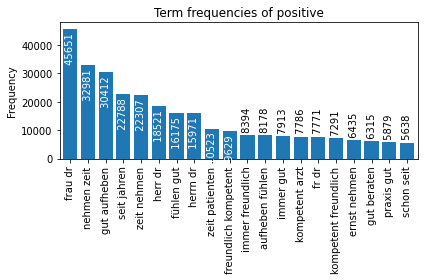

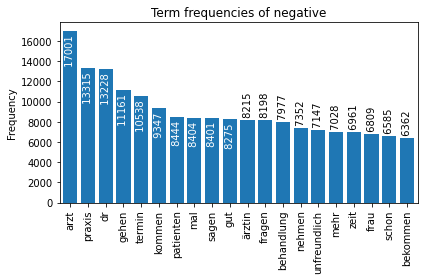

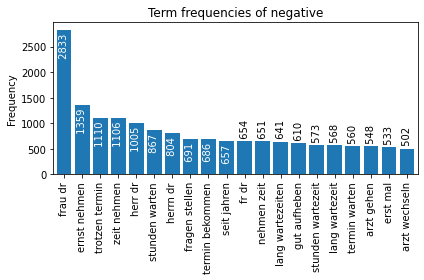

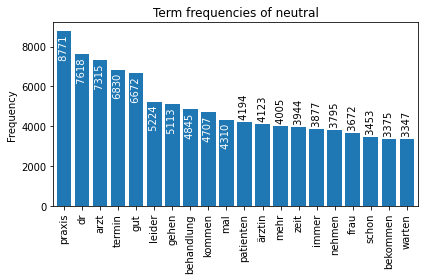

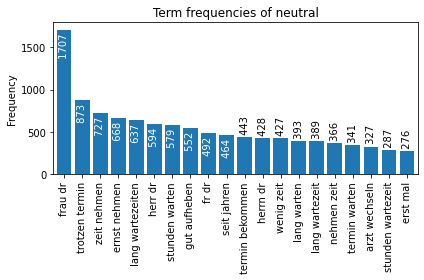

In [19]:
for label in data["label"].unique():
    ngrams_1 = create_ngram_counts(data.loc[(data["label"] == label)], 1)
    ngrams_2 = create_ngram_counts(data.loc[(data["label"] == label)], 2)
    
    plot_ngram_counts(ngrams_1, 20, "Term frequencies of "+label)
    plot_ngram_counts(ngrams_2, 20, "Term frequencies of "+label)

<font color='red'>**TASK: Extend the `stopwords` list with words which do not help to distinguish the classes or are so common that they are considered semantically empty. Additionally, you might want to remove words which can help to distinguish the classes (examine the stopword list).**</font>

In [20]:
# TODO: !!! place your code here !!!
####################################
    

###################
# TODO: !!! end !!!

Let's create a word cloud to further analyse frequent words...

In [21]:
%%capture

!pip install wordcloud

In [22]:
def create_word_cloud(df, label, field="token_lemma"):
    """Creates a wordcloud of a column of text

    Parameters
    ----------
    df : dataframe
        The dataframe
    label: str
        The label for which the wordcloud is generated (only for printing - df needs to be filtered in the calling code)
    field : str
        The column name to read from (default is token_lemma)
    """
        
    import matplotlib.pyplot as plt
    from collections import Counter
    from wordcloud import WordCloud
    
    counter = Counter()
    # see https://stackoverflow.com/a/17071908
    _ = df["token_lemma"].apply(counter.update)
    
    print(label, "- with", len(counter.keys()), "number of words.")

    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(counter)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

positive - with 142713 number of words.


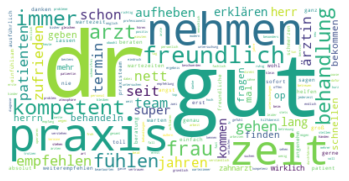

negative - with 60782 number of words.


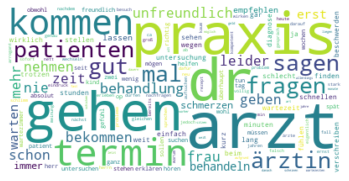

neutral - with 42342 number of words.


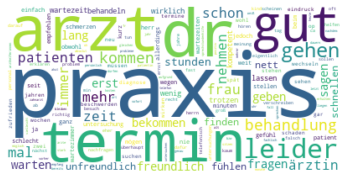

In [23]:
for label in data["label"].unique():
    create_word_cloud(data.loc[(data["label"] == label)], label, field="token_lemma")

Recreate the colums with the extended stopwords 

In [24]:
%%time
data = data.drop(columns=["token_lemma"], errors='ignore')
data = parallelize_dataframe(data, normalize, field_read="token_clean", field_write="token_lemma", stopwords=stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False)

CPU times: user 3min 43s, sys: 9.71 s, total: 3min 53s
Wall time: 6min 36s


In [25]:
%%time
data = parallelize_dataframe(data, normalize, field_read="token_clean", field_write="token_stem", stopwords=stopwords, stemmer=stemmer, lemmanizer=None, lemma_with_ner=False)

CPU times: user 1min 19s, sys: 3.85 s, total: 1min 23s
Wall time: 1min 34s


In [26]:
%%time
data = parallelize_dataframe(data, normalize, field_read="token_clean", field_write="token_clean_stopwords", stopwords=stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False)

CPU times: user 1min 19s, sys: 4.4 s, total: 1min 23s
Wall time: 1min 28s


In [27]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [28]:
%%time
save_dataframe(data, "data/german_doctor_reviews_pre_tokenized_02.parq")

CPU times: user 1min 7s, sys: 941 ms, total: 1min 8s
Wall time: 1min 8s


Resume if needed...

In [29]:
%%time

#data = None
if data is None:
    download("https://drive.google.com/uc?id=1lfs74a5kIISm0OZ_XZ5mhJN6yGmfPpih", "data/german_doctor_reviews_pre_tokenized_02.parq")
    data = load_dataframe("data/german_doctor_reviews_pre_tokenized_02.parq")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


In [30]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


<font color='blue'>**Idea: Let's try to extract simple text features which can be used to convert text into vectors so that they can be plotted in 3D and we can see visually if there are *outlier* (i.e. *strange*) reviews.**</font>

<font color='red'>**TASK: Implement `char_count`, `word_count` and `unique_words` and provide the functionality as described in the function documentation.**</font>

<font color='blue'>**Can you think of other simple features that can help to identify outlier/strange reviews?** Maybe [this](https://umap-learn.readthedocs.io/en/latest/outliers.html) could help but we would need an [embedding](https://umap-learn.readthedocs.io/en/latest/document_embedding.html) (i.e. vectors) first.</font>

In [31]:
def char_count(text):
    """Counts the characters of a text

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens
        
    Returns
    -------
    int
        The character count
    """
    from fhnw.nlp.utils.processing import is_iterable
        
    if isinstance(text, str):
        text = text
    elif is_iterable(text):
        from fhnw.nlp.utils.text import join_tokens
        text = join_tokens(text)
    else:
        raise TypeError("Only string or list is supported. Received a "+ str(type(text))) 

    # TODO: !!! place your code here !!!
    ####################################


    ###################
    # TODO: !!! end !!!
    

def word_count(text):
    """Counts the words of a text

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens
        
    Returns
    -------
    int
        The word count
    """
    from fhnw.nlp.utils.processing import is_iterable
        
    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(text)
    elif is_iterable(text):
        tokens = text
    else:
        raise TypeError("Only string or list is supported. Received a "+ str(type(text))) 
    
    # TODO: !!! place your code here !!!
    ####################################


    ###################
    # TODO: !!! end !!!
    

def unique_words(text):
    """Counts the unique words of a text

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens
        
    Returns
    -------
    int
        The unique word count
    """
    from fhnw.nlp.utils.processing import is_iterable
        
    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(text)
    elif is_iterable(text):
        tokens = text
    else:
        raise TypeError("Only string or list is supported. Received a "+ str(type(text)))

    # TODO: !!! place your code here !!!
    ####################################


    ###################
    # TODO: !!! end !!!


def extract_count_features_df(df, field_read="token_lemma"):
    """Extracts count features from a column of text (primarily meant for parallel processing)

    Parameters
    ----------
    df : dataframe
        The dataframe
    field_read : str
        The column name to read from (default is token_lemma)
        
    Returns
    -------
    dataframe
        The dataframe with the count features
    """    
    
    series_char_count = df[field_read].map(
        lambda x: char_count(x)
    )
    series_char_count.rename("char_count", copy=False, inplace=True)
    
    series_word_count = df[field_read].map(
        lambda x: word_count(x)
    )
    series_word_count.rename("word_count", copy=False, inplace=True)
        
    series_unique_words = df[field_read].map(
        lambda x: unique_words(x)
    )
    series_unique_words.rename("unique_words", copy=False, inplace=True)
    
    return pd.concat([series_char_count, series_word_count, series_unique_words], axis=1)

In [32]:
%%time
data = parallelize_dataframe(data, char_count, field_read="token_lemma", field_write="char_count")
data = parallelize_dataframe(data, word_count, field_read="token_lemma", field_write="word_count")
data = parallelize_dataframe(data, unique_words, field_read="token_lemma", field_write="unique_words")

CPU times: user 1min 44s, sys: 9.64 s, total: 1min 54s
Wall time: 1min 56s


The code below does the same calculation but in 1/3 of the time. Do you have an idea what could cause this difference?

In [33]:
%%time
parallelize_dataframe(data, extract_count_features_df, processing_mode="df", field_read="token_lemma")

CPU times: user 35.4 s, sys: 3.37 s, total: 38.8 s
Wall time: 39.8 s


,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords,char_count,word_count,unique_words,char_count,word_count,unique_words
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za...",144,19,18,144,19,18
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr...",223,26,25,223,26,25
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,...",107,13,13,107,13,13
3,Nachdem ich in der Klinik nur ungenaue Angaben...,1.0,Nachdem ich in der Klinik nur ungenaue Angaben...,positive,1,"[nachdem, ich, in, der, klinik, nur, ungenaue,...",nachdem ich in der klinik nur ungenaue angaben...,"[nachdem, klinik, ungenau, angaben, erhalten, ...","[nachd, klinik, ungenau, angab, erhalt, ,, spo...","[nachdem, klinik, ungenaue, angaben, erhalten,...",297,34,32,297,34,32
4,"Frau Dr. Vetter kenne ich seit vielen Jahren, ...",1.0,"Frau Dr. Vetter kenne ich seit vielen Jahren, ...",positive,1,"[frau, dr., vetter, kenne, ich, seit, vielen, ...","frau dr. vetter kenne ich seit vielen jahren ,...","[vetter, kennen, seit, jahren, problemen, komp...","[dr., vett, kenn, seit, viel, jahr, ,, viel, p...","[dr., vetter, kenne, seit, vielen, jahren, ,, ...",177,21,21,177,21,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357894,"War heute morgen bei ihr, nahm sich Zeit und h...",1.0,"War heute morgen bei ihr, nahm sich Zeit und h...",positive,1,"[war, heute, morgen, bei, ihr, ,, nahm, sich, ...","war heute morgen bei ihr , nahm sich zeit und ...","[heute, morgen, nehmen, zeit, ausreichen, bera...","[heut, morg, ,, nahm, zeit, ausreich, berat]","[heute, morgen, ,, nahm, zeit, ausreichend, be...",43,6,6,43,6,6
357895,Nachdem ich über zwei Monate bei verschiedenen...,1.0,Nachdem ich über zwei Monate bei verschiedenen...,positive,1,"[nachdem, ich, über, zwei, monate, bei, versch...",nachdem ich über zwei monate bei verschiedenen...,"[nachdem, zwei, monate, verschieden, ärzten, w...","[nachd, zwei, monat, verschied, arzt, weg, abs...","[nachdem, zwei, monate, verschiedenen, ärzten,...",365,39,37,365,39,37
357896,Ich war mit meinem Besuch bei Frau Dr. Sonntag...,1.0,Ich war mit meinem Besuch bei Frau Dr. Sonntag...,positive,1,"[ich, war, mit, meinem, besuch, bei, frau, dr....",ich war mit meinem besuch bei frau dr. sonntag...,"[besuch, sonntag, wirklich, zufrieden, nachdem...","[besuch, dr., sonntag, wirklich, zufried, ., n...","[besuch, dr., sonntag, wirklich, zufrieden, .,...",407,44,39,407,44,39
357897,Ich bin schon länger bei Frau Dr. Sonntag in B...,4.0,Ich bin schon länger bei Frau Dr. Sonntag in B...,neutral,0,"[ich, bin, schon, länger, bei, frau, dr., sonn...",ich bin schon länger bei frau dr. sonntag in b...,"[schon, lang, sonntag, behandlung, letztens, d...","[schon, lang, dr., sonntag, behandl, ., letzt,...","[schon, länger, dr., sonntag, behandlung, ., l...",354,47,41,354,47,41


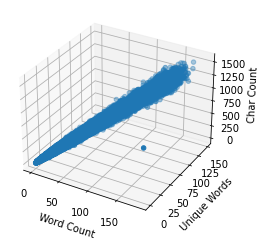

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["word_count"], data["unique_words"], data["char_count"])
# ax.scatter(data["word_count"], data["unique_words"], data["char_count"], s=data["char_count"])
ax.set_xlabel('Word Count')
ax.set_ylabel('Unique Words')
ax.set_zlabel('Char Count')

plt.show()

In [35]:
!pip install plotly

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import plotly
import plotly.express as px

fig = px.scatter_3d(data, x='word_count', y='unique_words', z='char_count', size_max=18, opacity=0.7) #color='cluster', size='char_count',

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

Try to identify outliers (by applying some filters) and remove them (if appropriate).

In [37]:
#pd.options.display.max_rows = None
#data.loc[data["word_count"] > 170]
data.query('(word_count < 1 and unique_words < 1)')

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords,char_count,word_count,unique_words
27685,weiter so,1.0,weiter so,positive,1,"[weiter, so]",weiter so,[],[],[],0,0,0
30426,Alles so wie es sein soll!,1.0,Alles so wie es sein soll!,positive,1,"[alles, so, wie, es, sein, soll, !]",alles so wie es sein soll !,[],[!],[!],0,0,0
31887,Aber das war es auch...,5.0,Aber das war es auch...,negative,-1,"[aber, das, war, es, auch, ...]",aber das war es auch ...,[],[...],[...],0,0,0
42173,Machen Sie weiter so!,1.0,Machen Sie weiter so!,positive,1,"[machen, sie, weiter, so, !]",machen sie weiter so !,[],[!],[!],0,0,0
81555,kann´s!,1.0,kann !,positive,1,"[kann, !]",kann !,[],[!],[!],0,0,0
161601,weiter so!,1.0,weiter so!,positive,1,"[weiter, so, !]",weiter so !,[],[!],[!],0,0,0
294667,ich würde es wieder dort machen,1.0,ich würde es wieder dort machen,positive,1,"[ich, würde, es, wieder, dort, machen]",ich würde es wieder dort machen,[],[],[],0,0,0
319012,So wie es sein soll,1.0,So wie es sein soll,positive,1,"[so, wie, es, sein, soll]",so wie es sein soll,[],[],[],0,0,0


In [38]:
data = data.query('~(word_count < 1 and unique_words < 1)')

In [39]:
data.query('word_count > 20 and unique_words < 5 or word_count > 110 and unique_words < 45')

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords,char_count,word_count,unique_words
92350,Top Top Top Top Top Top Top TopTop Top Top Top...,1.0,Top Top Top Top Top Top Top TopTop Top Top Top...,positive,1,"[top, top, top, top, top, top, top, toptop, to...",top top top top top top top toptop top top top...,"[top, top, top, top, top, top, top, toptop, to...","[top, top, top, top, top, top, top, toptop, to...","[top, top, top, top, top, top, top, toptop, to...",916,185,2
127512,sehr gut sehr gutsehr gutsehr gutsehr gutsehr ...,1.0,sehr gut sehr gutsehr gutsehr gutsehr gutsehr ...,positive,1,"[sehr, gut, sehr, gutsehr, gutsehr, gutsehr, g...",sehr gut sehr gutsehr gutsehr gutsehr gutsehr ...,"[gut, gutsehr, gutsehr, gutsehr, gutsehr, guts...","[gut, gutsehr, gutsehr, gutsehr, gutsehr, guts...","[gut, gutsehr, gutsehr, gutsehr, gutsehr, guts...",183,24,2


In [40]:
data = data.query('~(word_count > 20 and unique_words < 5 or word_count > 110 and unique_words < 45)')

In [41]:
data = data.drop(columns=["char_count", "word_count", "unique_words"], errors='ignore')

In [42]:
%%time
save_dataframe(data, "data/german_doctor_reviews_tokenized.parq")

CPU times: user 1min 6s, sys: 750 ms, total: 1min 7s
Wall time: 1min 7s
